In [1]:
%pylab inline 
import pandas as pd
import os 
import plotly.express as px
import matplotlib.pyplot as plt
import itertools 
from matplotlib import gridspec
import plotly.io as pio
import seaborn as sns
import warnings
plt.style.use('seaborn')
warnings.filterwarnings('ignore')
pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'

Populating the interactive namespace from numpy and matplotlib


In [2]:
#get correct columns names
cols = pd.read_csv('/scratch4/jluo2/drabiza1/ICI_data/BQSR_BAM/columns.txt', sep = '\t', header = None)
cols = cols.loc[0]
cols = list(cols)[9:]
samples = pd.read_csv('PaperON/samples.txt', sep = '\n', header = None)
samps = list(samples[0])

In [3]:
dup74 = np.load('dup74.npy')

In [28]:
#np.save('Manuscript_Exome/BP_files/Annovar_Edit/GATK_BP_COLS.npy',array(list(new_rename_cols.values())))

# Filtering & Making Truth Sets

In [15]:
vcf_header = ['CHROM',  'POS', 'ID',  'REF' , 'ALT' ,'QUAL' ,'FILTER' ,'INFO' , 'FORMAT' , 'SAMPLE']

In [49]:
def get_sor(x):
    return(float(x.split('SOR=')[1].split(';')[0]))
def get_FS(x):
    return(float(x.split('FS=')[1].split(';')[0]))
def get_MQ(x):
    return(float(x.split('MQ=')[1].split(';')[0]))
def get_QD(x):
    return(float(x.split('QD=')[1].split(';')[0]))
def get_MQRankSum(x):
    try: 
        return(float(x.split('MQRankSum=')[1].split(';')[0]))
    except: 
        return 0
def get_GQ(x):
    try: 
        return int(x.split(':')[-2])
    except: 
        return 0
def get_AF(x):
    return(float(x.split('AF=')[1].split(';')[0]))

# Make Truth Sets

In [37]:
repeats = np.load('Manuscript_Exome/Pileup/repeat_errors.npy')
supdups = np.load('Manuscript_Exome/Pileup/supdups.npy')
DV_repeats = np.load('Manuscript_Exome/Pileup/repeat_errors.npy')
DV_supdups = np.load('Manuscript_Exome/Pileup/supdups.npy')

In [ ]:
for i in {59..73}; 
do  cd Rep$i ;
bcftools view tp-baseline.vcf.gz -R /scratch4/jluo2/drabiza1/ICI_data/hg19_Exome_splice.bed -O z -o filt.tp-baseline.vcf.gz; 
bcftools view fp.vcf.gz -R /scratch4/jluo2/drabiza1/ICI_data/hg19_Exome_splice.bed -O z -o filt.fp.vcf.gz; 
bcftools view fn.vcf.gz -R /scratch4/jluo2/drabiza1/ICI_data/hg19_Exome_splice.bed -O z -o filt.fn.vcf.gz; 
cd ..; echo $i ; done

In [ ]:
#move old folders
for i in range(59, 74):
    os.system('mv Manuscript_Exome/Combined_VCFEVAL/Rep{} Manuscript_Exome/Combined_VCFEVAL/TRIPS_QUADS/'.format(i) )

In [ ]:
for Rep in range(59,74):
    all_df = pd.DataFrame()
    #low_cov = np.load('Manuscript_Exome/Pileup/LowCov/Rep{}.npy'.format(str(Rep)))
    for file in ['filt.fn.vcf.gz', 'filt.tp-baseline.vcf.gz', 'filt.fp.vcf.gz']: #filtered for exome only 
        df = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/Rep{}/{}'.format( Rep,file), sep ='\t', comment = '#', header = None)
        df.columns = vcf_header
        df = df.set_index(df['CHROM']+'_'+df['POS'].astype(str))
        #remove_low_cov = list(set(low_cov).intersection(list(df.index)))
        #df = df.drop(remove_low_cov)
        remove_supdups = list(set(supdups).intersection(list(df.index)))
        df = df.drop(remove_supdups)
        remove_repeats = list(set(repeats).intersection(list(df.index)))
        df = df.drop(remove_repeats)
        #again for DV
        remove_supdups = list(set(DV_supdups).intersection(list(df.index)))
        df = df.drop(remove_supdups)
        remove_repeats = list(set(DV_repeats).intersection(list(df.index)))
        df = df.drop(remove_repeats)
        if file == 'filt.fn.vcf.gz':
            df[~df['INFO'].str.contains('NEGATIVE')]
            df = df[df['INFO'].apply(get_sor)<3]
            df = df[df['INFO'].apply(get_FS)<10]
            #df = df[df['INFO'].apply(get_QD)>3]
            #df = df[df['INFO'].apply(get_MQRankSum)>-1.5]
            #df = df[df['FILTER']=='PASS']
        all_df = pd.concat([all_df,df ])
    all_df = all_df.sort_values(['CHROM', 'POS'])
    head = pd.read_csv('Manuscript_Exome/FULL_GATK_Header.txt', sep ='\n', header = None)
    head = '\n'.join(list(head[0]))
    head = head.replace('46A', 'Rep'+str(Rep))
    output_VCF = "Manuscript_Exome/Combined_VCFEVAL/Baseline/Rep{}.vcf".format(str(Rep))
    with open(output_VCF, 'w') as vcf:
        vcf.write(head+'\n')
    all_df.to_csv(output_VCF, sep="\t", mode='a', index=False, header = None)
    print('Rep'+str(Rep))


### Make Pileups

In [ ]:
- I have to go though each one of the discordant calls and remove it if the corresponding call's coverage is less than X
- I think I'll have to do it through merging the calls without RTG


In [35]:
df = pd.read_csv('Manuscript_Exome/DV_JG/VCF/105A_S66_final.bam.vcf.gz', sep = '\t',
                 comment = '#', header = None)
df.columns = vcf_header
df = df.set_index('ID')
df = df.rename(columns ={'SAMPLE':100})
df1 = pd.read_csv('Manuscript_Exome/DV_JG/VCF/100A_S63_final.bam.vcf.gz', sep = '\t',
                 comment = '#', header = None)
df1.columns = vcf_header
df1 = df1.set_index('ID')
df1 = df1.rename(columns ={'SAMPLE':101})

# Low Cov for Gatk and DV
- Add 0 coverage 


In [117]:
#DV Pileup with GATK calls 
DV_delete = {}
for group_num, group in enumerate(dup74): 
    group_remove = []
    for sample in group: 
        df = pd.read_csv('Manuscript_Exome/Pileup/DV_Pileups/{}.txt'.format(sample.split('.vcf')[0]), 
                                    sep = '\t', header = None, usecols = [0,1,3])
        check_df = pd.read_csv('Manuscript_Exome/GATK_VCFEVAL/VCF_Replicates/filt.{}'.format(sample), sep = '\t', comment = '#', header = None)
        pile_index = list(df[0]+'_'+df[1].astype(str))
        call_index = list(check_df[0]+'_'+check_df[1].astype(str))
        ind_remove = []
        for i in pile_index: 
            if i not in call_index: 
                ind_remove.append(i)
        df = df.set_index(df[0]+'_'+df[1].astype(str))
        ind = df.loc[ind_remove][3]<10
        group_remove = group_remove+list(ind[ind].index)
        #remove Zeroes
        df = pd.read_csv('Manuscript_Exome/Pileup/DV_Lists/{}.list'.format(sample.split('.vcf')[0]), sep ='\t', header = None)
        df = df.set_index(df[0]+'_'+df[1].astype(str))
        remove_zerocov = []
        for i in df.index: 
            if i not in pile_index:
                remove_zerocov.append(i)
        group_remove = group_remove + remove_zerocov        
    DV_delete[group_num] = group_remove 

In [138]:
#GATK Pileup with DV calls 
GATK_delete = {}
for group_num, group in enumerate(dup74): 
    group_remove = []
    for sample in group: 
        df = pd.read_csv('Manuscript_Exome/Pileup/GATK_Pileups/{}.txt'.format(sample.split('.vcf')[0]), 
                                    sep = '\t', header = None, usecols = [0,1,3])
        check_df = pd.read_csv('Manuscript_Exome/DV_JG/VCF/filt.{}'.format(sample), sep = '\t', comment = '#', header = None)
        pile_index = list(df[0]+'_'+df[1].astype(str))
        call_index = list(check_df[0]+'_'+check_df[1].astype(str))
        ind_remove = []
        for i in pile_index: 
            if i not in call_index: 
                ind_remove.append(i)
        df = df.set_index(df[0]+'_'+df[1].astype(str))
        ind = df.loc[ind_remove][3]<10
        group_remove = group_remove+list(ind[ind].index)
        #remove Zeroes
        df = pd.read_csv('Manuscript_Exome/Pileup/GATK_Lists/{}.list'.format(sample.split('.vcf')[0]), sep ='\t', header = None)
        df = df.set_index(df[0]+'_'+df[1].astype(str))
        remove_zerocov = []
        for i in df.index: 
            if i not in pile_index:
                remove_zerocov.append(i)
        group_remove = group_remove + remove_zerocov 
    GATK_delete[group_num] = group_remove 

In [140]:
#Combine
low_cov_ind = {}
for i in range(len(dup74)):
    low_cov_ind[i] = unique(GATK_delete[i]+DV_delete[i])

In [141]:
#import superdups
GATK_supdups = np.load('Manuscript_Exome/Pileup/supdups.npy')
DV_supdups = np.load('Manuscript_Exome/Pileup/supdups.npy')

GATK_repeats = np.load('Manuscript_Exome/Pileup/repeat_errors.npy')
DV_repeats = np.load('Manuscript_Exome/Pileup/repeat_errors.npy')

vcf_header = ['CHROM',  'POS', 'ID',  'REF' , 'ALT' ,'QUAL' ,'FILTER' ,'INFO' , 'FORMAT' , 'SAMPLE']

# Call set 

In [ ]:
#DV - Make Callset
for ind, group in enumerate(dup74[59:]): 
    ind = ind+59
    low_cov = low_cov_ind[ind]
    for sample in group: 
        df = pd.read_csv('Manuscript_Exome/DV_JG/VCF/filt.{}'.format(sample), sep ='\t', comment = '#', header = None)
        df.columns = vcf_header
        df = df.set_index(df['CHROM']+'_'+df['POS'].astype(str))
        a = time.time()
        group_low_cov = unique(list(group_remove[ind])+list(low_cov))
        remove_low_cov = list(set(group_low_cov).intersection(list(df.index)))
        df = df.drop(remove_low_cov)
        remove_sup_dups = list(set(DV_supdups).intersection(list(df.index)))
        df = df.drop(remove_sup_dups)
        remove_repeats = list(set(DV_repeats).intersection(list(df.index)))
        df = df.drop(remove_repeats)
        print(time.time() - a)
            #elif i in repeats: 
            #    remove_ind.append(i)
        head = pd.read_csv('Manuscript_Exome/FULL_DV_Header.txt', sep ='\n', header = None)
        head = '\n'.join(list(head[0]))
        head = head.replace('456', str(ind))
        output_VCF = "Manuscript_Exome/Combined_VCFEVAL/DV_Callset/{}".format(sample.split('.gz')[0])
        with open(output_VCF, 'w') as vcf:
            vcf.write(head+'\n')
        df.to_csv(output_VCF, sep="\t", mode='a', index=False, header = None)
        print(sample)
        
        

In [ ]:
#GATK
for ind, group in enumerate(dup74[59:]): 
    ind = ind+59
    low_cov = low_cov_ind[ind]
    for sample in group: 
        df = pd.read_csv('Manuscript_Exome/GATK_VCFEVAL/VCF_Replicates/filt.{}'.format(sample), sep ='\t', comment = '#', header = None)
        df.columns = vcf_header
        df = df.set_index(df['CHROM']+'_'+df['POS'].astype(str))
        a = time.time()
        group_low_cov = unique(list(group_remove[ind])+list(low_cov))
        remove_low_cov = list(set(group_low_cov).intersection(list(df.index)))
        df = df.drop(remove_low_cov)
        remove_sup_dups = list(set(GATK_supdups).intersection(list(df.index)))
        df = df.drop(remove_sup_dups)
        remove_repeats = list(set(GATK_repeats).intersection(list(df.index)))
        df = df.drop(remove_repeats)
        print(time.time() - a)
            #elif i in repeats: 
            #    remove_ind.append(i)
        head = pd.read_csv('Manuscript_Exome/FULL_GATK_Header.txt', sep ='\n', header = None)
        head = '\n'.join(list(head[0]))
        head = head.replace('46A', str(ind))
        output_VCF = "Manuscript_Exome/Combined_VCFEVAL/GATK_Callset/{}".format(sample.split('.gz')[0])
        with open(output_VCF, 'w') as vcf:
            vcf.write(head+'\n')
        df.to_csv(output_VCF, sep="\t", mode='a', index=False, header = None)
        print(sample)
        
        

# Training set 
- Which callers 
- SNP or INDEL , Length of Indel
- Bases [0,1,2,3]
- AD, DP, GQ, GT , VAF
- FS, SOR, QD, MQRankSum
- QUAL, FILTER 



In [18]:
def Format_DF_GATK(path, low_cov, caller ):
    df = pd.read_csv(path, sep = '\t', comment= '#', header = None)
    temp = df[0]+'_'+df[1].astype(str)
    df = df[np.invert(temp.isin(low_cov))]
    Train = pd.DataFrame()
    Train['SNP_INDEL'] = df[3].apply(len) - df[4].apply(len)
    status = df[6]=='PASS'
    Train['Filter']= status.replace(True,0).replace(False,1)
    status = df[7].str.contains('NEGATIVE')
    Train['Negative'] = status.replace(True,0).replace(False,1)
    status = df[7].str.contains('POSITIVE')
    Train['Positive'] = status.replace(True,0).replace(False,1)
    Train['Qual'] = df[5]
    Train['SOR'] = df[7].apply(get_sor)
    Train['FS'] = df[7].apply(get_FS)
    Train['QD'] = df[7].apply(get_QD)
    Train['FS'] = df[7].apply(get_FS)
    Train['MQRANK'] = df[7].apply(get_MQRankSum)
    Train = pd.concat([Train,df[9].str.split(':', expand=True)[[0,2,3]].rename(columns={0:'GT',
                                                                                        2:'DP', 3:'GQ'}) ], axis =1)
    Train = pd.concat([Train,df[9].str.split(':', expand=True)[[1]][1].str.split(',', 
                                                                     expand=True).rename(columns={0:'RD', 1:'AD'})],
                       axis =1)
    Train['GT'] = Train['GT'].replace('0/1', 0).replace('0|1', 0).replace('1/1',
                    1).replace('1|1', 1).replace('1/0', 0).replace('1|0', '0')
    Train = Train.astype(float)
    Train['VAF'] = Train['AD']/Train['DP']
    Train['Caller'] = [caller for i in range(Train.shape[0])]
    return Train

In [19]:
def Format_DF_DV(path,low_cov, caller ):
    df = pd.read_csv(path, sep = '\t', comment= '#', header = None)
    temp = df[0]+'_'+df[1].astype(str)
    df = df[np.invert(temp.isin(low_cov))]
    Train = pd.DataFrame()
    Train['SNP_INDEL'] = df[3].apply(len) - df[4].apply(len)
    Train['Qual'] = df[5]
    Train['AQ'] = df[7].str.split(';', expand=True)[1].str.split('=', expand=True)[1]
    Train = pd.concat([Train,df[9].str.split(':', expand=True)[[0,1,3]].rename(columns={0:'GT',
                                                                                        1:'DP', 3:'GQ'}) ], axis =1)
    Train = pd.concat([Train,df[9].str.split(':', expand=True)[2].str.split(',', 
                                                                     expand=True).rename(columns={0:'RD', 1:'AD'})],
                       axis =1)
    Train['GT'] = Train['GT'].replace('0/1', 0).replace('0|1', 0).replace('1/1',
                    1).replace('1|1', 1).replace('1/0', 0).replace('1|0', 0).replace('./1', 1 )
    Train = Train.replace('.', 0)
    Train = Train.astype(float)
    Train['VAF'] = Train['AD']/Train['DP']
    Train['Caller'] = [caller for i in range(Train.shape[0])]
    return Train

Looks like for DV will need more samples because there are fewer variants 

### Make Training and Test sets

In [ ]:
#Train 
#Take groups - vcfeval them and then take each against the Truth set 

cnt = 0 
for i in re_order[0:20]:
    samp = i[0]
    command = "rtg vcfeval -b GATK_Callset/{} -c DV_Callset/{} --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o TRAIN/{}".format(
    samp, samp, cnt )
    cnt+=1
    os.system("cd Manuscript_Exome/Combined_VCFEVAL/; sbatch -t 00:10:00 --wrap='ml anaconda; conda activate bio;{}'".format(command))
    

In [ ]:
#Train
cnt = 0 
group=0
for i in re_order[0:20]:
    
    samp = i[0]
    command = "rtg vcfeval -b Baseline/Rep{}.vcf.gz -c TRAIN/{}/tp-baseline.vcf.gz --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o TRAIN/{}_tp".format(
    group, cnt ,cnt)
    os.system("cd Manuscript_Exome/Combined_VCFEVAL/;sbatch -t 00:10:00 --wrap='ml anaconda; conda activate bio;{}'".format(command))
    command = "rtg vcfeval -b Baseline/Rep{}.vcf.gz -c TRAIN/{}/fn.vcf.gz --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o TRAIN/{}_fn".format(
    group, cnt ,cnt)
    os.system("cd Manuscript_Exome/Combined_VCFEVAL/;sbatch -t 00:10:00 --wrap='ml anaconda; conda activate bio;{}'".format(command))
    command = "rtg vcfeval -b Baseline/Rep{}.vcf.gz -c TRAIN/{}/fp.vcf.gz --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o TRAIN/{}_fp".format(
    group, cnt ,cnt)
    os.system("cd Manuscript_Exome/Combined_VCFEVAL/;sbatch -t 00:10:00 --wrap='ml anaconda; conda activate bio;{}'".format(command))
    cnt+=1
    group+=1
    

In [ ]:
#Test
cnt = 5
for i in re_order[7:12]:
    cnt+=1
    samp = i[0]
    command = "rtg vcfeval -b GATK_Callset/{} -c DV_Callset/{} --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o TRAIN/{}".format(
    samp, samp, cnt )
    print(command)

In [ ]:
#Test
cnt = 5
group=7
for i in re_order[7:12]:
    cnt+=1
    samp = i[0]
    command = "rtg vcfeval -b Baseline/Rep{}.vcf.gz -c TRAIN/{}/tp-baseline.vcf.gz --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o TRAIN/{}_tp".format(
    group, cnt ,cnt)
    print(command)
    command = "rtg vcfeval -b Baseline/Rep{}.vcf.gz -c TRAIN/{}/fn.vcf.gz --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o TRAIN/{}_fn".format(
    group, cnt ,cnt)
    print(command)
    command = "rtg vcfeval -b Baseline/Rep{}.vcf.gz -c TRAIN/{}/fp.vcf.gz --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o TRAIN/{}_fp".format(
    group, cnt ,cnt)
    print(command)
    group+=1
    

# GATK - import train and test 

In [20]:
#GATK
#LETS ONLY FILTLER GATK ONLY and DV ONLY
#for i in re_order[2:7]:
True_df = pd.DataFrame()
False_df = pd.DataFrame()
group=0
for i in range(0,10):
    low_cov = low_cov_ind[group]
    string = 'Manuscript_Exome/Combined_VCFEVAL/TRAIN/{}_fn/tp.vcf.gz'.format(i)
    df = Format_DF_GATK(string,low_cov,1)
    True_df = pd.concat([True_df, df])
    string = 'Manuscript_Exome/Combined_VCFEVAL/TRAIN/{}_fn/fp.vcf.gz'.format(i)
    df = Format_DF_GATK(string,low_cov,1)
    False_df = pd.concat([False_df, df])
    group+=1
y = [0 for i in range(True_df.shape[0])] + [1 for i in range(False_df.shape[0])]
X = pd.concat([True_df, False_df])
X = X.to_numpy()    

In [21]:
#GATK - TEST
True_df = pd.DataFrame()
False_df = pd.DataFrame()
group=10
for i in range(10,20):
    low_cov = low_cov_ind[group]
    string = 'Manuscript_Exome/Combined_VCFEVAL/TRAIN/{}_fn/tp.vcf.gz'.format(i)
    df = Format_DF_GATK(string,low_cov,1)
    True_df = pd.concat([True_df, df])
    string = 'Manuscript_Exome/Combined_VCFEVAL/TRAIN/{}_fn/fp.vcf.gz'.format(i)
    df = Format_DF_GATK(string,low_cov,1)
    False_df = pd.concat([False_df, df])
    group+=1
y_test = [0 for i in range(True_df.shape[0])] + [1 for i in range(False_df.shape[0])]
X_test = pd.concat([True_df, False_df])
X_test = X_test.fillna(0)
X_test = X_test.to_numpy()    

# DV - import train and test

In [22]:
#DV
#LETS ONLY FILTLER GATK ONLY and DV ONLY
#for i in re_order[2:7]:
True_df = pd.DataFrame()
False_df = pd.DataFrame()
group=0
for i in range(0,15):
    low_cov = low_cov_ind[group]
    string = 'Manuscript_Exome/Combined_VCFEVAL/TRAIN/{}_fp/tp.vcf.gz'.format(i)
    df = Format_DF_DV(string,low_cov,1)
    True_df = pd.concat([True_df, df])
    string = 'Manuscript_Exome/Combined_VCFEVAL/TRAIN/{}_fp/fp.vcf.gz'.format(i)
    df = Format_DF_DV(string,low_cov,1)
    False_df = pd.concat([False_df, df])
    group+=1
y_dv = [0 for i in range(True_df.shape[0])] + [1 for i in range(False_df.shape[0])]
X_dv = pd.concat([True_df, False_df])
X_dv = X_dv.to_numpy()    

In [23]:
#DV - TEST
True_df = pd.DataFrame()
False_df = pd.DataFrame()
group=15
for i in range(15,20):
    low_cov = low_cov_ind[group]
    string = 'Manuscript_Exome/Combined_VCFEVAL/TRAIN/{}_fp/tp.vcf.gz'.format(i)
    df = Format_DF_DV(string,low_cov,1)
    True_df = pd.concat([True_df, df])
    string = 'Manuscript_Exome/Combined_VCFEVAL/TRAIN/{}_fp/fp.vcf.gz'.format(i)
    df = Format_DF_DV(string,low_cov,1)
    False_df = pd.concat([False_df, df])
    group+=1
y_dv_test = [0 for i in range(True_df.shape[0])] + [1 for i in range(False_df.shape[0])]
X_dv_test = pd.concat([True_df, False_df])
X_dv_test = X_dv_test.to_numpy()    

In [26]:
var = 'chr8_145170704'
low_cov = low_cov_ind[0]
print(var in GATK_supdups)
print(var in DV_supdups)
print(var in DV_repeats)
print(var in GATK_repeats)
print(var in low_cov)

False
False
False
False
True


# Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#X, y = make_classification(n_samples=1000, n_features=4,
#                           n_informative=2, n_redundant=0,
#                           random_state=0, shuffle=False)


In [33]:
#Choosing GATK
#Lets say choose 7 
for i in range(2,16):
    GATK_clf = RandomForestClassifier(max_depth=i)
    GATK_clf.fit(X, y)
    print(GATK_clf.score(X_test,y_test), i )

0.8328203155059638 2
0.8480184686417853 3
0.8476337052712581 4
0.850327048864948 5
0.8568680261639092 6
0.8703347441323586 7
0.8718737976144671 8
0.8737976144671027 9
0.8759138130050019 10
0.8755290496344748 11
0.8739899961523663 12
0.8770681031165833 13
0.8766833397460562 14
0.873220469411312 15


In [32]:
#Choosing DV
for i in range(2,16):
    DV_clf = RandomForestClassifier(max_depth=i)
    DV_clf.fit(X_dv, y_dv)
    print(DV_clf.score(X_dv_test,y_dv_test), i)

0.6952380952380952 2
0.7183673469387755 3
0.7170068027210884 4
0.7482993197278912 5
0.7401360544217687 6
0.7537414965986394 7
0.7523809523809524 8
0.7646258503401361 9
0.763265306122449 10
0.7578231292517007 11
0.7605442176870748 12
0.7673469387755102 13
0.7687074829931972 14
0.7551020408163265 15


In [31]:
from sklearn.naive_bayes import GaussianNB
clf= GaussianNB()
clf.fit(X_dv, y_dv)
print(DV_clf.score(X_dv_test,y_dv_test))

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_dv, y_dv)
print(clf.score(X_dv_test,y_dv_test))

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_dv, y_dv)
print(clf.score(X_dv_test,y_dv_test))

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_dv, y_dv)
print(clf.score(X_dv_test,y_dv_test))

0.7578231292517007
0.5265306122448979
0.6952380952380952
0.7278911564625851


# Save Model 

In [36]:
GATK_clf = RandomForestClassifier(max_depth=7)
GATK_clf.fit(X, y)
DV_clf = RandomForestClassifier(max_depth=7)
DV_clf.fit(X_dv, y_dv)

RandomForestClassifier(max_depth=7)

In [35]:
import pickle
with open('Manuscript_Exome/GATK_RF.pkl','wb') as f:
    pickle.dump(GATK_clf,f)
with open('Manuscript_Exome/DV_RF.pkl','wb') as f:
    pickle.dump(DV_clf,f)

In [158]:
# load
import pickle
with open('Manuscript_Exome/GATK_RF.pkl', 'rb') as f:
    GATK_clf = pickle.load(f)
with open('Manuscript_Exome/DV_RF.pkl', 'rb') as f:
    DV_clf = pickle.load(f)

# Hybrid Model 

In [153]:
def Format_DV(path):
    df = pd.read_csv(path, sep = '\t', comment= '#', header = None)
    Train = pd.DataFrame()
    Train['SNP_INDEL'] = df[3].apply(len) - df[4].apply(len)
    Train['Qual'] = df[5]
    Train['AQ'] = df[7].str.split(';', expand=True)[1].str.split('=', expand=True)[1]
    Train = pd.concat([Train,df[9].str.split(':', expand=True)[[0,1,3]].rename(columns={0:'GT',
                                                                                        1:'DP', 3:'GQ'}) ], axis =1)
    Train = pd.concat([Train,df[9].str.split(':', expand=True)[2].str.split(',', 
                                                                     expand=True).rename(columns={0:'RD', 1:'AD'})],
                       axis =1)
    Train['GT'] = Train['GT'].replace('0/1', 0).replace('0|1', 0).replace('1/1',
                    1).replace('1|1', 1).replace('1/0', 0).replace('1|0', 0).replace('./1', 1 )
    Train = Train.replace('.', 0)
    Train = Train.astype(float)
    Train['VAF'] = Train['AD']/Train['DP']
    Train['Caller'] = [1 for i in range(Train.shape[0])]
    Train = Train.fillna(0)
    results = DV_clf.predict(Train.to_numpy() )
    return df.loc[where(results==0)[0]]

In [154]:
def Format_GATK(path):
    df = pd.read_csv(path, sep = '\t', comment= '#', header = None)
    Train = pd.DataFrame()
    Train['SNP_INDEL'] = df[3].apply(len) - df[4].apply(len)
    status = df[6]=='PASS'
    Train['Filter']= status.replace(True,0).replace(False,1)
    status = df[7].str.contains('NEGATIVE')
    Train['Negative'] = status.replace(True,0).replace(False,1)
    status = df[7].str.contains('POSITIVE')
    Train['Positive'] = status.replace(True,0).replace(False,1)
    Train['Qual'] = df[5]
    Train['SOR'] = df[7].apply(get_sor)
    Train['FS'] = df[7].apply(get_FS)
    Train['QD'] = df[7].apply(get_QD)
    Train['FS'] = df[7].apply(get_FS)
    Train['MQRANK'] = df[7].apply(get_MQRankSum)
    Train = pd.concat([Train,df[9].str.split(':', expand=True)[[0,2,3]].rename(columns={0:'GT',
                                                                                        2:'DP', 3:'GQ'}) ], axis =1)
    Train = pd.concat([Train,df[9].str.split(':', expand=True)[[1]][1].str.split(',', 
                                                                     expand=True).rename(columns={0:'RD', 1:'AD'})],axis =1)
    Train['GT'] = Train['GT'].replace('0/1', 0).replace('0|1', 0).replace('1/1',
                    1).replace('1|1', 1).replace('1/0', 0).replace('1|0', '0')
    Train = Train.astype(float)
    Train['VAF'] = Train['AD']/Train['DP']
    Train['Caller'] = [1 for i in range(Train.shape[0])]
    Train = Train.fillna(0)
    #predict 
    results = GATK_clf.predict(Train.to_numpy() )
    return df.loc[where(results==0)[0]]

In [155]:
def hybrid(gatk_samp, dv_samp, file_name, output_file):
    #os.system('ml anaconda; conda activate bio')
    command = "ml anaconda; conda activate bio;rtg vcfeval -b {} -c {} --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o {}".format(gatk_samp, dv_samp, file_name)
    os.system(command)
    #import each of the fp and fn with the existing function (slighlt modified), run each model. Keep the ones that are predicted to be true. 
    gatk = Format_GATK(file_name+'/fn.vcf.gz')
    dv = Format_DV(file_name+'/fp.vcf.gz')
    both = pd.read_csv(file_name+'/tp-baseline.vcf.gz', sep = '\t', comment= '#', header = None)
    all_df = pd.concat([both,gatk,dv ])
    all_df.columns = vcf_header
    all_df = all_df.sort_values(['CHROM', 'POS'])
    
    head = pd.read_csv('Manuscript_Exome/FULL_GATK_Header.txt', sep ='\n', header = None)
    head = '\n'.join(list(head[0]))
    head = head.replace('46A', file_name)
    output_VCF = output_file+'.vcf'

    with open(output_VCF, 'w') as vcf:
        vcf.write(head+'\n')
    all_df.to_csv(output_VCF, sep="\t", mode='a', index=False, header = None)
    

In [ ]:
for group in dup74[59:]: 
    for sample in group: 
        hybrid('Manuscript_Exome/Combined_VCFEVAL/GATK_Callset/{}'.format(sample), 
              'Manuscript_Exome/Combined_VCFEVAL/DV_Callset/{}'.format(sample), 
              'RTG/{}'.format(sample.split('_final')[0]),
               'Manuscript_Exome/Combined_VCFEVAL/HYBRID/{}'.format(sample.split('.vcf')[0]) )
        print(sample)

In [175]:
for i in range(59, 74):
    for sample in dup74[i]:
        os.system('rm -r Manuscript_Exome/Combined_VCFEVAL/RESULTS/*/{}'.format(sample.split('_final')[0] ))

In [ ]:
for num, group in enumerate(dup74[59:]): 
    num = num + 59
    for sample in group: 
        os.system('sbatch -t 00:20:00 --wrap="ml anaconda; conda activate bio;rtg vcfeval -b Manuscript_Exome/Combined_VCFEVAL/Baseline/Rep{}.vcf.gz -c Manuscript_Exome/Combined_VCFEVAL/GATK_PASS/{} --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o Manuscript_Exome/Combined_VCFEVAL/RESULTS/GATK/{}"'.format(
        str(num),sample, sample.split('_final')[0] )) 
        os.system('sbatch -t 00:20:00 --wrap="ml anaconda; conda activate bio;rtg vcfeval -b Manuscript_Exome/Combined_VCFEVAL/Baseline/Rep{}.vcf.gz -c Manuscript_Exome/Combined_VCFEVAL/DV_PASS/{} --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o Manuscript_Exome/Combined_VCFEVAL/RESULTS/DV/{}"'.format(
        str(num),sample, sample.split('_final')[0] )) 
        os.system('sbatch -t 00:20:00 --wrap="ml anaconda; conda activate bio;rtg vcfeval -b Manuscript_Exome/Combined_VCFEVAL/Baseline/Rep{}.vcf.gz -c Manuscript_Exome/Combined_VCFEVAL/HYBRID/{} --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o Manuscript_Exome/Combined_VCFEVAL/RESULTS/HYBRID/{}"'.format(
        str(num),sample, sample.split('_final')[0] )) 
        
        

In [ ]:
for num, group in enumerate(dup74[59:]): 
    num = num + 59
    for sample in group: 
        os.system('sbatch -t 00:20:00 --wrap="perl /scratch4/jluo2/drabiza1/Annovar/table_annovar.pl /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/Combined_VCFEVAL/DV_Callset/{} /scratch4/jluo2/drabiza1/Annovar/humandb/ -buildver hg19 -out /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/Combined_VCFEVAL/ANNO/PRE_DV/{} -remove -protocol refGene,clinvar_20220320,gnomad211_exome,dbnsfp42c -operation g,f,f,f -nastring . -vcfinput -polish"'.format(sample, sample.split('_final')[0]) ) 
        os.system('sbatch -t 00:20:00 --wrap="perl /scratch4/jluo2/drabiza1/Annovar/table_annovar.pl /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/Combined_VCFEVAL/GATK_Callset/{} /scratch4/jluo2/drabiza1/Annovar/humandb/ -buildver hg19 -out /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/Combined_VCFEVAL/ANNO/PRE_GATK/{} -remove -protocol refGene,clinvar_20220320,gnomad211_exome,dbnsfp42c -operation g,f,f,f -nastring . -vcfinput -polish"'.format(sample, sample.split('_final')[0]) ) 
        os.system('sbatch -t 00:20:00 --wrap="perl /scratch4/jluo2/drabiza1/Annovar/table_annovar.pl /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/Combined_VCFEVAL/HYBRID/{} /scratch4/jluo2/drabiza1/Annovar/humandb/ -buildver hg19 -out /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/Combined_VCFEVAL/ANNO/PRE_HYBRID/{} -remove -protocol refGene,clinvar_20220320,gnomad211_exome,dbnsfp42c -operation g,f,f,f -nastring . -vcfinput -polish"'.format(sample, sample.split('_final')[0]) ) 



In [ ]:
for group in range(74):
    num = str(group)
    os.system('sbatch -t 00:20:00 --wrap="perl /scratch4/jluo2/drabiza1/Annovar/table_annovar.pl /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/Combined_VCFEVAL/Baseline/Rep{}.vcf.gz /scratch4/jluo2/drabiza1/Annovar/humandb/ -buildver hg19 -out /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/Combined_VCFEVAL/ANNO/PRE_BASELINE/Rep{} -remove -protocol refGene,clinvar_20220320,gnomad211_exome,dbnsfp42c -operation g,f,f,f -nastring . -vcfinput -polish"'.format(num, num )) 
       

In [178]:
def Rare_Pathogenic(path):
    dv = pd.read_csv(path, sep ='\t')
    
    dv = dv[dv['Func.refGene'].isin(['exonic', 'splicing'])]
    dv = dv[np.invert(dv['CLNSIG'].str.contains('Benign'))]
    dv = dv[np.invert(dv['CLNSIG'].str.contains('benign'))]
    dv = dv[np.invert(dv['ExonicFunc.refGene'].str.contains('nonframeshift'))]
    dv = dv[dv['AF'].replace('.', 0).astype(float)<.005]
    dv = dv[dv['ExonicFunc.refGene']!='synonymous SNV']
    keep = dv['CLNSIG'].isin(['Pathogenic', 'Pathogenic/Likely_pathogenic','Likely_pathogenic'])
    path_ind = list(keep[keep].index)
    drop = dv[(dv['ExonicFunc.refGene']=='nonsynonymous SNV')]['ClinPred_score'].replace('.', 0).astype(float)<0.85
    drop = drop[drop].index
    drop_ind = [i for i in drop if i not in path_ind]
    dv = dv.drop(drop_ind)
    return dv[dv.columns[-10:]]

In [ ]:
def GATK_filter(all_df):
    all_df = all_df[all_df['Otherinfo9']>350]
    all_df = all_df[all_df['Otherinfo10']=='PASS']
    return all_df
def DV_filter(all_df):
    all_df = all_df[all_df['Otherinfo9']>10]
    return all_df

In [180]:
def write_vcf(all_df,output_file, Type='GATK'):
    all_df.columns = vcf_header
    all_df = all_df.sort_values(['CHROM', 'POS'])
    if Type=='GATK':
        head = pd.read_csv('Manuscript_Exome/FULL_GATK_Header.txt', sep ='\n', header = None)
        head = '\n'.join(list(head[0]))
        head = head.replace('46A', '0')
    else:
        head = pd.read_csv('Manuscript_Exome/FULL_DV_Header.txt', sep ='\n', header = None)
        head = '\n'.join(list(head[0]))
        head = head.replace('456', '0')
        
    
    output_VCF = 'Manuscript_Exome/Combined_VCFEVAL/ANNO/'+output_file+'.vcf'
    with open(output_VCF, 'w') as vcf:
        vcf.write(head+'\n')
    all_df.to_csv(output_VCF, sep="\t", mode='a', index=False, header = None)

In [ ]:
#GATK
for group in dup74[59:]: 
    for sample in group:
        samp = sample.split('_final')[0]
        path = 'Manuscript_Exome/Combined_VCFEVAL/ANNO/PRE_GATK/{}.hg19_multianno.txt'.format(samp)
        all_df = Rare_Pathogenic(path)
        all_df = GATK_filter(all_df)
        write_vcf(all_df, 'FILT_GATK/'+sample.split('.vcf')[0], Type='GATK')
        print(sample)

In [ ]:
#Hybrid
for group in dup74[59:]: 
    for sample in group:
        samp = sample.split('_final')[0]
        path = 'Manuscript_Exome/Combined_VCFEVAL/ANNO/PRE_HYBRID/{}.hg19_multianno.txt'.format(samp)
        all_df = Rare_Pathogenic(path)
        write_vcf(all_df, 'FILT_HYBRID/'+sample.split('.vcf')[0], Type='GATK')
        print(sample)

In [ ]:
#DV
for group in dup74[59:]: 
    for sample in group:
        samp = sample.split('_final')[0]
        path = 'Manuscript_Exome/Combined_VCFEVAL/ANNO/PRE_DV/{}.hg19_multianno.txt'.format(samp)
        all_df = Rare_Pathogenic(path)
        all_df = DV_filter(all_df)
        write_vcf(all_df, 'FILT_DV/'+sample.split('.vcf')[0], Type='DV')
        print(sample)

In [ ]:
#Baseline
for group in range(len(dup74)): 
        path = 'Manuscript_Exome/Combined_VCFEVAL/ANNO/PRE_BASELINE/Rep{}.hg19_multianno.txt'.format(str(group))
        all_df = Rare_Pathogenic(path)
        write_vcf(all_df, 'FILT_BASELINE/Rep'+str(group), Type='GATK')
        print(group)

In [189]:
#move old 
for i in range(59, 74):
    for sample in dup74[i]:
        os.system('rm -r Manuscript_Exome/Combined_VCFEVAL/RESULTS/ANNO/*/{}'.format(sample.split('_final')[0] ))

In [ ]:
# run RTG on RarePathogenic

In [ ]:
for num, group in enumerate(dup74[59:]): 
    num = num +59 
    for sample in group: 
        os.system('sbatch -t 00:20:00 --wrap="ml anaconda; conda activate bio;rtg vcfeval -b Manuscript_Exome/Combined_VCFEVAL/ANNO/FILT_BASELINE/Rep{}.vcf.gz -c Manuscript_Exome/Combined_VCFEVAL/ANNO/FILT_GATK/{} --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o Manuscript_Exome/Combined_VCFEVAL/RESULTS/ANNO/GATK/{}"'.format(
        str(num),sample, sample.split('_final')[0] )) 
        os.system('sbatch -t 00:20:00 --wrap="ml anaconda; conda activate bio;rtg vcfeval -b Manuscript_Exome/Combined_VCFEVAL/ANNO/FILT_BASELINE/Rep{}.vcf.gz -c Manuscript_Exome/Combined_VCFEVAL/ANNO/FILT_DV/{} --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o Manuscript_Exome/Combined_VCFEVAL/RESULTS/ANNO/DV/{}"'.format(
        str(num),sample, sample.split('_final')[0] )) 
        os.system('sbatch -t 00:20:00 --wrap="ml anaconda; conda activate bio;rtg vcfeval -b Manuscript_Exome/Combined_VCFEVAL/ANNO/FILT_BASELINE/Rep{}.vcf.gz -c Manuscript_Exome/Combined_VCFEVAL/ANNO/FILT_HYBRID/{} --all-records --squash-ploidy --no-roc -t /scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/hg19_SDF/ -o Manuscript_Exome/Combined_VCFEVAL/RESULTS/ANNO/HYBRID/{}"'.format(
        str(num),sample, sample.split('_final')[0] )) 

# Import Results 

In [4]:
master_plot = [[], [], []]

In [9]:
tp = []
fp = []
fn = []
for num, group in enumerate(dup74[20:]): 
    sample = group[0]
    sample = sample.split('_final')[0]
    df = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/RESULTS/ANNO/GATK/{}/summary.txt'.format(sample), sep ='\s+')
    tp.append(df.loc[1]['True-pos-baseline'])
    fp.append(df.loc[1]['False-pos'])
    fn.append(df.loc[1]['False-neg'])
spec = sum(tp)/(sum(tp)+sum(fp))
sens = sum(tp)/(sum(tp)+sum(fn))
F_meas = (2*spec*sens)/(sens+spec)
print('GATK:')
print('TP:', sum(tp), 'FP:', sum(fp), 'FN:', sum(fn))
print('Sensitivity:', sens )
print('Specififity:', spec)
print('F-measure:', F_meas)
master_plot[0].append(sens), master_plot[1].append(spec), master_plot[2].append(F_meas)

GATK:
TP: 2678.0 FP: 509.0 FN: 337.0
Sensitivity: 0.8882255389718077
Specififity: 0.8402886727329777
F-measure: 0.8635923895517574


(None, None, None)

In [10]:
tp = []
fp = []
fn = []
for num, group in enumerate(dup74[20:]): 
    sample = group[0]
    sample = sample.split('_final')[0]
    df = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/RESULTS/ANNO/DV/{}/summary.txt'.format(sample), sep ='\s+')
    tp.append(df.loc[1]['True-pos-baseline'])
    fp.append(df.loc[1]['False-pos'])
    fn.append(df.loc[1]['False-neg'])
spec = sum(tp)/(sum(tp)+sum(fp))
sens = sum(tp)/(sum(tp)+sum(fn))
F_meas = (2*spec*sens)/(sens+spec)
print('DV:')
print('TP:', sum(tp), 'FP:', sum(fp), 'FN:', sum(fn))
print('Sensitivity:', sens)
print('Specififity:', spec)
print('F-measure:', F_meas)
master_plot[0].append(sens), master_plot[1].append(spec), master_plot[2].append(F_meas)

DV:
TP: 2683.0 FP: 276.0 FN: 332.0
Sensitivity: 0.8898839137645108
Specififity: 0.9067252450152078
F-measure: 0.8982256444593236


(None, None, None)

In [11]:
tp = []
fp = []
fn = []
for num, group in enumerate(dup74[20:]): 
    sample = group[0]
    sample = sample.split('_final')[0]
    df = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/RESULTS/ANNO/HYBRID/{}/summary.txt'.format(sample), sep ='\s+')
    tp.append(df.loc[1]['True-pos-baseline'])
    fp.append(df.loc[1]['False-pos'])
    fn.append(df.loc[1]['False-neg'])
spec = sum(tp)/(sum(tp)+sum(fp))
sens = sum(tp)/(sum(tp)+sum(fn))
F_meas = (2*spec*sens)/(sens+spec)
print('HYBRID:')
print('TP:', sum(tp), 'FP:', sum(fp), 'FN:', sum(fn))
print('Sensitivity:', sens)
print('Specififity:', spec)
print('F-measure:', F_meas)
master_plot[0].append(sens), master_plot[1].append(spec), master_plot[2].append(F_meas)

HYBRID:
TP: 2893.0 FP: 108.0 FN: 122.0
Sensitivity: 0.9595356550580432
Specififity: 0.9640119960013329
F-measure: 0.9617686170212767


(None, None, None)

In [22]:
#plt.rcParams["font.family"] = "cursive"
#matplotlib.rcParams['text.usetex'] = True

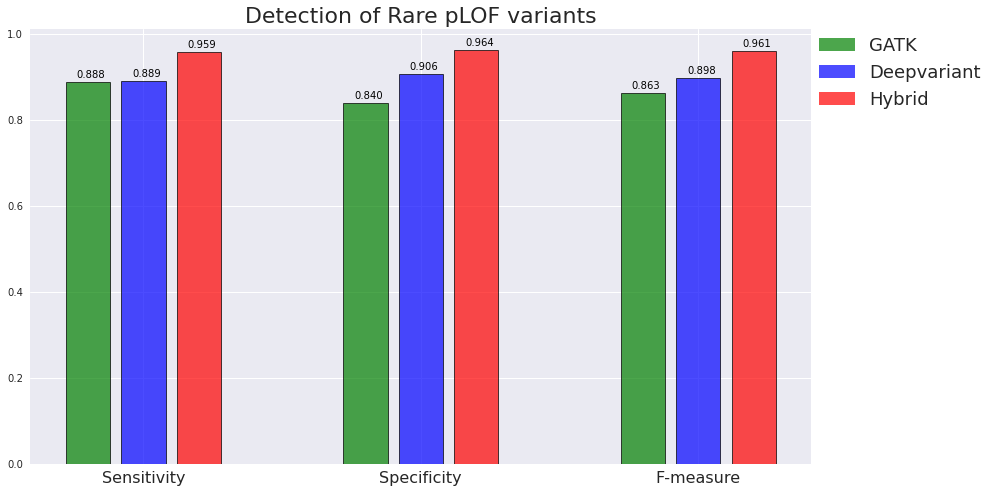

In [8]:
plt.figure(figsize=(14,8))
plt.bar([0,1,2, 5,6,7, 10,11,12], hstack(master_plot), color =['green', 'blue', 'red'], 
       alpha = 0.7, edgecolor = 'black', linewidth=1)
plt.bar(0,0, color='g', alpha =0.7, label='GATK')
plt.bar(0,0, color='b', alpha =0.7, label='Deepvariant')
plt.bar(0,0, color='r', alpha =0.7, label='Hybrid')
plt.legend(fontsize=18, loc=(1,.8))
plt.xticks([1,6,11], ['Sensitivity', 'Specificity', 'F-measure'], fontsize =16)
plt.title('Detection of Rare pLOF variants', fontsize = 22)
for ind, i in enumerate([0,1,2, 5,6,7, 10,11,12]):
    plt.text(i-0.2, hstack(master_plot)[ind]+.01, str(hstack(master_plot)[ind])[0:5] , color='black')
    
plt.show()

In [202]:
def get_summary(caller):
    tp = []
    fp = []
    fn = []
    for num, group in enumerate(dup74[20:]): 
        sample = group[0]
        sample = sample.split('_final')[0]
        df = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/RESULTS/{}/{}/summary.txt'.format(caller,sample), sep ='\s+')
        tp.append(df.loc[1]['True-pos-baseline'])
        fp.append(df.loc[1]['False-pos'])
        fn.append(df.loc[1]['False-neg'])
    spec = sum(tp)/(sum(tp)+sum(fp))
    sens = sum(tp)/(sum(tp)+sum(fn))
    F_meas = (2*spec*sens)/(sens+spec)
    return sens, spec, F_meas

In [203]:
master_plot = [[], [], []]
sens, spec , F = get_summary( 'GATK')
master_plot[0].append(sens), master_plot[1].append(spec), master_plot[2].append(F)
sens, spec , F = get_summary('DV')
master_plot[0].append(sens), master_plot[1].append(spec), master_plot[2].append(F)
sens, spec , F = get_summary('HYBRID')
master_plot[0].append(sens), master_plot[1].append(spec), master_plot[2].append(F)

(None, None, None)

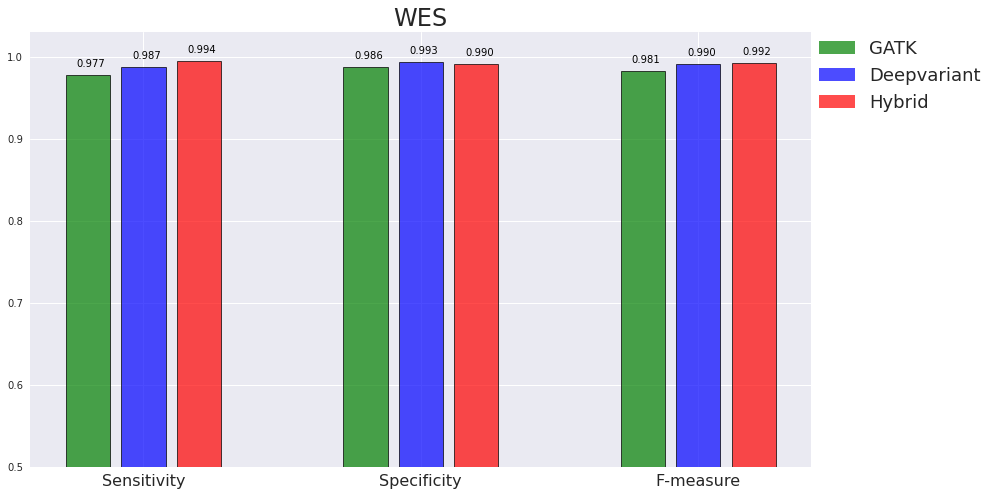

In [204]:
plt.figure(figsize=(14,8))
plt.bar([0,1,2, 5,6,7, 10,11,12], hstack(master_plot), color =['green', 'blue', 'red'], 
       alpha = 0.7, edgecolor = 'black', linewidth=1)
plt.bar(0,0, color='g', alpha =0.7, label='GATK')
plt.bar(0,0, color='b', alpha =0.7, label='Deepvariant')
plt.bar(0,0, color='r', alpha =0.7, label='Hybrid')
plt.legend(fontsize=18, loc=(1,.8))
plt.xticks([1,6,11], ['Sensitivity', 'Specificity', 'F-measure'], fontsize =16)
plt.title('WES', fontsize = 24)
for ind, i in enumerate([0,1,2, 5,6,7, 10,11,12]):
    plt.text(i-0.2, hstack(master_plot)[ind]+.01, str(hstack(master_plot)[ind])[0:5] , color='black')
ylim(0.5,1.03)
plt.show()

In [13]:
coverage = {}
for group in dup74:
    #print('Group')
    for samp in group:
        samp1 = samp.split('.vcf')[0]
        try1 = os.popen('cat PaperON/Coverage/'+samp1+'.txt').read()
        coverage[samp] = float(try1.split('\n')[0].split('=  ')[1])
    

In [14]:
low = []
high = []
for num, group in enumerate(dup74[20:]): 
    if coverage[group[0]] <=40:
        low.append(group[0])
    elif coverage[group[1]]<=40:
        low.append(group[1])
    elif coverage[group[0]]>=60:
        high.append(group[0])
    elif coverage[group[1]]>=60:
        high.append(group[1])
print(len(low), len(high))

18 30


In [15]:
def get_summary(caller, low_high):
    tp = []
    fp = []
    fn = []
    for sample in low_high:
        sample = sample.split('_final')[0]
        df = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/RESULTS/ANNO/{}/{}/summary.txt'.format(caller,sample), sep ='\s+')
        tp.append(df.loc[1]['True-pos-baseline'])
        fp.append(df.loc[1]['False-pos'])
        fn.append(df.loc[1]['False-neg'])
    spec = sum(tp)/(sum(tp)+sum(fp))
    sens = sum(tp)/(sum(tp)+sum(fn))
    print('TP:', sum(tp), 'FP:', sum(fp), 'FN:', sum(fn))
    F_meas = (2*spec*sens)/(sens+spec)
    return sens, spec, F_meas

In [16]:
master_plot = [[], [], []]
sens, spec , F = get_summary('GATK', high)
master_plot[0].append(sens), master_plot[1].append(spec), master_plot[2].append(F)
sens, spec , F = get_summary('DV', high)
master_plot[0].append(sens), master_plot[1].append(spec), master_plot[2].append(F)
sens, spec , F = get_summary('HYBRID', high)
master_plot[0].append(sens), master_plot[1].append(spec), master_plot[2].append(F)

TP: 1554.0 FP: 252.0 FN: 174.0
TP: 1507.0 FP: 138.0 FN: 221.0
TP: 1658.0 FP: 47.0 FN: 70.0


(None, None, None)

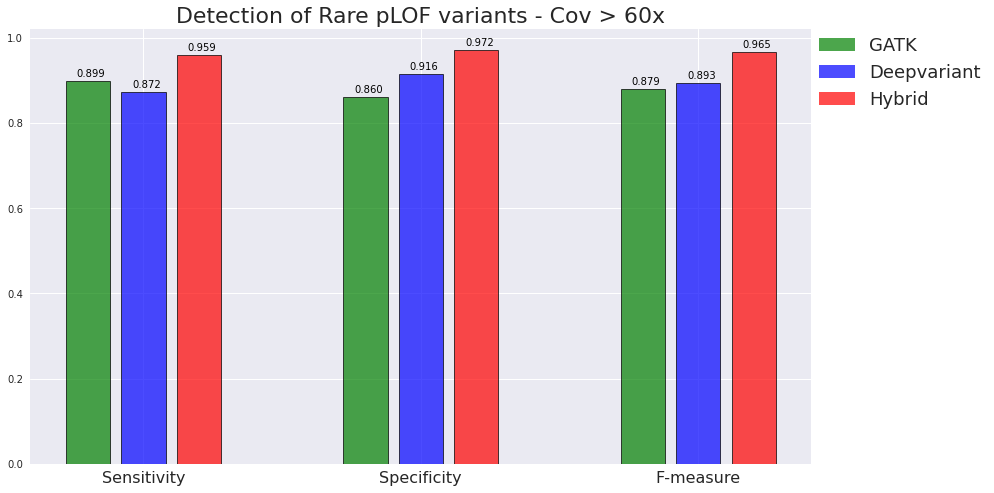

In [209]:
plt.figure(figsize=(14,8))
plt.bar([0,1,2, 5,6,7, 10,11,12], hstack(master_plot), color =['green', 'blue', 'red'], 
       alpha = 0.7, edgecolor = 'black', linewidth=1)
plt.bar(0,0, color='g', alpha =0.7, label='GATK')
plt.bar(0,0, color='b', alpha =0.7, label='Deepvariant')
plt.bar(0,0, color='r', alpha =0.7, label='Hybrid')
plt.legend(fontsize=18, loc=(1,.8))
plt.xticks([1,6,11], ['Sensitivity', 'Specificity', 'F-measure'], fontsize =16)
plt.title('Detection of Rare pLOF variants - Cov > 60x', fontsize = 22)
for ind, i in enumerate([0,1,2, 5,6,7, 10,11,12]):
    plt.text(i-0.2, hstack(master_plot)[ind]+.01, str(hstack(master_plot)[ind])[0:5] , color='black')
plt.show()

In [210]:
master_plot = [[], [], []]
sens, spec , F = get_summary('GATK', low)
master_plot[0].append(sens), master_plot[1].append(spec), master_plot[2].append(F)
sens, spec , F = get_summary('DV', low)
master_plot[0].append(sens), master_plot[1].append(spec), master_plot[2].append(F)
sens, spec , F = get_summary('HYBRID', low)
master_plot[0].append(sens), master_plot[1].append(spec), master_plot[2].append(F)

(None, None, None)

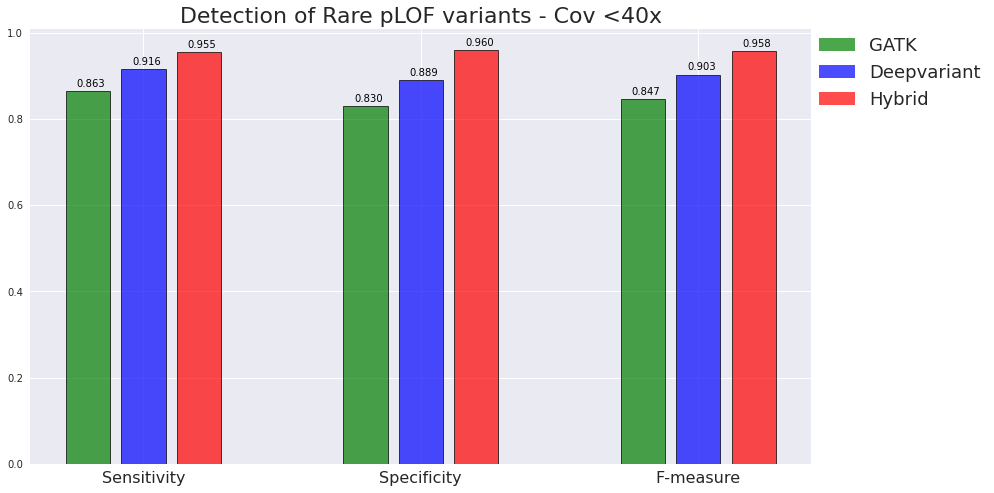

In [211]:
plt.figure(figsize=(14,8))
plt.bar([0,1,2, 5,6,7, 10,11,12], hstack(master_plot), color =['green', 'blue', 'red'], 
       alpha = 0.7, edgecolor = 'black', linewidth=1)
plt.bar(0,0, color='g', alpha =0.7, label='GATK')
plt.bar(0,0, color='b', alpha =0.7, label='Deepvariant')
plt.bar(0,0, color='r', alpha =0.7, label='Hybrid')
plt.legend(fontsize=18, loc=(1,.8))
plt.xticks([1,6,11], ['Sensitivity', 'Specificity', 'F-measure'], fontsize =16)
plt.title('Detection of Rare pLOF variants - Cov <40x', fontsize = 22)
for ind, i in enumerate([0,1,2, 5,6,7, 10,11,12]):
    plt.text(i-0.2, hstack(master_plot)[ind]+.01, str(hstack(master_plot)[ind])[0:5] , color='black')
plt.show()

In [17]:
def get_summary(caller, low_high):
    tp = []
    fp = []
    fn = []
    for sample in low_high:
        sample = sample.split('_final')[0]
        df = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/RESULTS/ANNO/{}/{}/summary.txt'.format(caller,sample), sep ='\s+')
        tp.append(df.loc[1]['True-pos-baseline'])
        fp.append(df.loc[1]['False-pos'])
        fn.append(df.loc[1]['False-neg'])
    spec = sum(tp)/(sum(tp)+sum(fp))
    sens = sum(tp)/(sum(tp)+sum(fn))
    F_meas = (2*spec*sens)/(sens+spec)
    return sens, spec, F_meas

In [18]:
gatk = pd.DataFrame()
per = []
sen = []
fm = []
caller = 'GATK'
for group in dup74[20:]:
    sample = group[0]
    sample = sample.split('_final')[0]
    df = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/RESULTS/ANNO/{}/{}/summary.txt'.format(caller,sample), sep ='\s+')
    per.append(df.loc[1]['Precision'])
    sen.append(df.loc[1]['Sensitivity'])
    fm.append(df.loc[1]['F-measure'])

gatk = pd.DataFrame()
gatk['value'] = per +sen +fm
gatk['metric'] = ['Specificity' for i in range(54)] + ['Sensitivity' for i in range(54)] + ['F-measure' for i in range(54)]
gatk['caller'] = ['GATK' for i in range(54*3)]


In [19]:
dv = pd.DataFrame()
per = []
sen = []
fm = []
caller = 'DV'
for group in dup74[20:]:
    sample = group[0]
    sample = sample.split('_final')[0]
    df = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/RESULTS/ANNO/{}/{}/summary.txt'.format(caller,sample), sep ='\s+')
    per.append(df.loc[1]['Precision'])
    sen.append(df.loc[1]['Sensitivity'])
    fm.append(df.loc[1]['F-measure'])

dv = pd.DataFrame()
dv['value'] = per +sen +fm
dv['metric'] = ['Specificity' for i in range(54)] + ['Sensitivity' for i in range(54)] + ['F-measure' for i in range(54)]
dv['caller'] = ['Deepvariant' for i in range(54*3)]

In [20]:
hybrid = pd.DataFrame()
per = []
sen = []
fm = []
caller = 'HYBRID'
for group in dup74[20:]:
    sample = group[0]
    sample = sample.split('_final')[0]
    df = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/RESULTS/ANNO/{}/{}/summary.txt'.format(caller,sample), sep ='\s+')
    per.append(df.loc[1]['Precision'])
    sen.append(df.loc[1]['Sensitivity'])
    fm.append(df.loc[1]['F-measure'])

hybrid = pd.DataFrame()
hybrid['value'] = per +sen +fm
hybrid['metric'] = ['Specificity' for i in range(54)] + ['Sensitivity' for i in range(54)] + ['F-measure' for i in range(54)]
hybrid['caller'] = ['Hybrid' for i in range(54*3)]

In [21]:
plotdf = pd.concat([gatk, dv, hybrid])

In [22]:
fig = px.box(plotdf, y="value", facet_col="metric", color="caller", points = None, 
            color_discrete_sequence=[ "green", "blue", "red"])
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

In [4]:
def make_axis(num):
    xaxis = []
    skip = 0 
    for i in list(range(num*4)): 
        if skip  < 2: 
            xaxis.append(i)
            skip +=1
        elif skip == 2:
            skip +=1
        elif skip ==3: 
            skip =0
    JIpos = arange(0.5, max(xaxis)+0.5, 4)   
    return xaxis, JIpos

In [77]:
def UpPair(df, vspacing = 0, title='UpPair',title_fontsize =18, plot_type='scatter', point_color = 'black',
          marker = "^", upper_ylabel = "Jaccard Index", upper_color = 'red', upper_legend = False, connected = 'None',
          upper_ymin = 0.5, upper_ymax = 1, lower_color = 'green', color1 ='lightgreen', color2 = None, 
          lower_ylabel = None, lower_xlabel = 'Samples', tick_labels = None, intersection_width = 2.5,
          intersection_label = None, label1 = None, label2 = None, style = 'ggplot'):
    plt.style.use(style)
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(18)
    xaxis, JIpos = make_axis(df.shape[0])
    spec = gridspec.GridSpec(ncols=1, nrows=2,
                             width_ratios=[1], wspace=0.1,
                             hspace=vspacing, height_ratios=[1, 2])
    twin1 = fig.add_subplot(spec[0])
    plt.title(title, fontsize=title_fontsize)
    p2 = twin1.plot(JIpos, df['JI'], label=upper_ylabel, color = point_color, 
                        marker = marker, linestyle = connected, markersize=12)
    twin1.set_ylabel(upper_ylabel, fontsize=14)
    twin1.yaxis.label.set_color(upper_color)
    twin1.tick_params(axis='y', colors=upper_color, labelsize=14 )
    if upper_legend==True:
        twin1.legend()
    #SHADING

    twin1.set_ylim(upper_ymin, upper_ymax)  #Also change this
    alph =0.1
    grades = (upper_ymax-upper_ymin)/5
    for h in range(1,6):
        twin1.axhspan(upper_ymin+((h-1)*grades), upper_ymin+(h*grades), alpha=alph, lw=0, color=upper_color)
        alph +=0.14
    
    twin1.tick_params(axis ='x',bottom = False)
    twin1.set_xticklabels( [])

    if color2==None: 
        color2=color1
    ax = fig.add_subplot(spec[1])
    ax.bar(xaxis[::2], df['P1'], color = color1, 
           label = label1, edgecolor='black', alpha = 0.7, linewidth = 1)
    ax.bar(xaxis[1:][::2], df['P2'], color = color2, 
           label = label2, edgecolor='black', alpha = 0.7, linewidth = 1)
    ax.bar(JIpos, df['Intersection'], width = intersection_width, alpha =0.7, color =lower_color, 
           edgecolor='black', label = intersection_label)
    ax.legend()
    ax.set_xticks(JIpos)
    ax.tick_params(axis='y', colors='black' , labelsize=14 )
    ax.yaxis.label.set_color('black')
    ax.set_ylabel(lower_ylabel, fontsize=18)
    ax.set_xlabel(lower_xlabel, fontsize=18)
    ax.set_xticklabels( tick_labels, rotation =45)
    ax.set_ylim(0, 110)

    plt.show()

In [81]:
JI = []
P1 = []
P2 = []
INTER = []
caller = 'HYBRID'
for group in dup74[20:]:
    df1 = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/ANNO/FILT_{}/{}'.format(caller,group[0]), 
                     sep ='\s+', comment = '#', header = None)
    df1 = df1[df1[7].apply(get_AF)<0.1] #remove repeats
    df2 = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/ANNO/FILT_{}/{}'.format(caller,group[1]), 
                     sep ='\s+', comment = '#', header = None)
    df2 = df2[df2[7].apply(get_AF)<0.1] #remove repeats
    p1 = len(set(df1[1]))
    p2 = len(set(df2[1]))
    inter = len(list(  set(df1[1]) &   set(df2[1])   ))
    ji = inter /len(unique(list(df2[1]) +list(df1[1])))
    JI.append(ji)
    P1.append(p1)
    P2.append(p2)
    INTER.append(inter)
        
df = pd.DataFrame()
df['P1'] = P1
df['P2'] = P2
df['Intersection'] = INTER
df['JI'] = JI

No handles with labels found to put in legend.


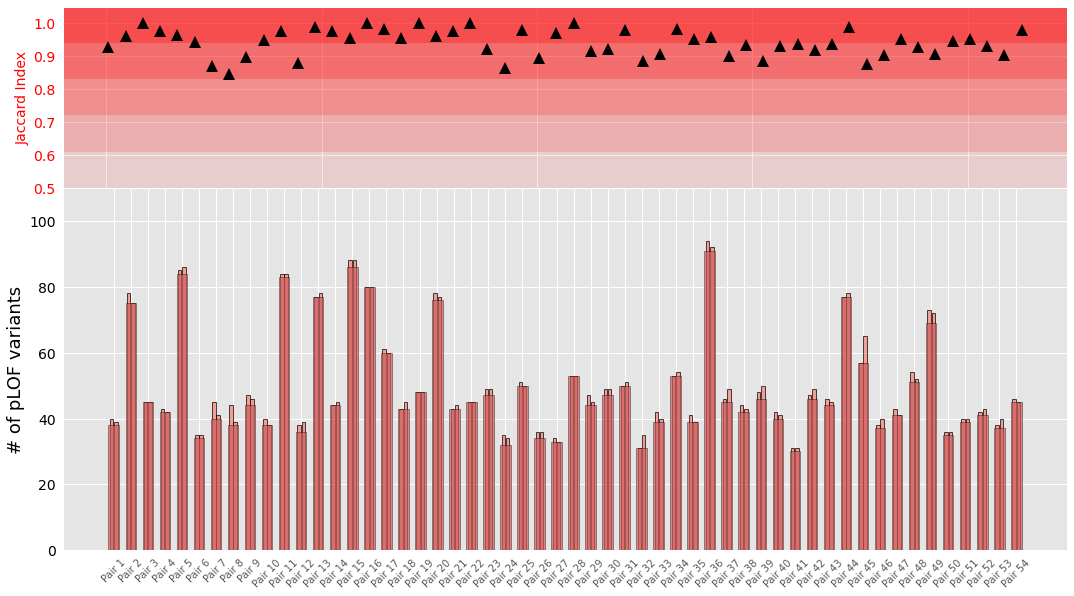

In [82]:
ticks = ['Pair '+str(i+1) for i in range(54)]
UpPair(df, vspacing = 0, title=None,title_fontsize =18, plot_type='scatter', point_color = 'black',
          marker = "^", upper_ylabel = "Jaccard Index", upper_color = 'red', upper_legend = False, connected = 'None',
          upper_ymin = 0.5, upper_ymax = 1.05, lower_color = 'indianred', color1 ='salmon', color2 = None, 
          lower_ylabel ='# of pLOF variants', lower_xlabel = None, tick_labels = ticks, intersection_width = 2.5,
          intersection_label = None, label1 = None, label2 = None, style = 'ggplot')

In [42]:

INTER = []
for caller in ['GATK','DV']:
    for group in dup74[20:21]:
        df1 = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/ANNO/FILT_{}/{}'.format(caller,group[0]), 
                         sep ='\s+', comment = '#', header = None)
        df2 = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/ANNO/FILT_{}/{}'.format(caller,group[1]), 
                         sep ='\s+', comment = '#', header = None)
        p1 = len(set(df1[1]))
        p2 = len(set(df2[1]))
        inter = list(  set(df1[1]) &   set(df2[1])   )
        INTER.append(inter)

In [30]:
temp = []
for i in INTER[0]:
    if i not in INTER[1]:
        temp.append(i)

In [30]:
temp = []
for i in INTER[0]:
    if i not in INTER[1]:
        temp.append(i)

In [33]:
INTER = []
for caller in ['GATK']:
    for group in dup74[20:21]:
        df1 = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/ANNO/FILT_{}/{}'.format(caller,group[0]), 
                         sep ='\s+', comment = '#', header = None)
        df2 = pd.read_csv('Manuscript_Exome/Combined_VCFEVAL/ANNO/FILT_{}/{}'.format(caller,group[1]), 
                         sep ='\s+', comment = '#', header = None)
        p1 = len(set(df1[1]))
        p2 = len(set(df2[1]))
        inter = list(  set(df1[1]) &   set(df2[1])   )
        INTER.append(inter)